In [1]:
# 1.) What was the change in price of the stock over time?
# 2.) What was the daily return of the stock on average?
# 3.) What was the moving average of the various stocks?
# 4.) What was the correlation between different stocks'?
# 5.) How much value do we put at risk by investing in a particular stock?
# 6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# Scale the data
from sklearn.preprocessing import MinMaxScaler

# Keras with the model
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #, root_mean_squared_error

# For time stamps
from datetime import datetime

# The tech stocks we'll use for this analysis
tech_list = ['AAPL']

end = datetime.now()
start = datetime(end.year - 15, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [AAPL]
company_name = ["APPLE"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name


[*********************100%%**********************]  1 of 1 completed


In [3]:
# Get the stock quote
df = AAPL.copy()

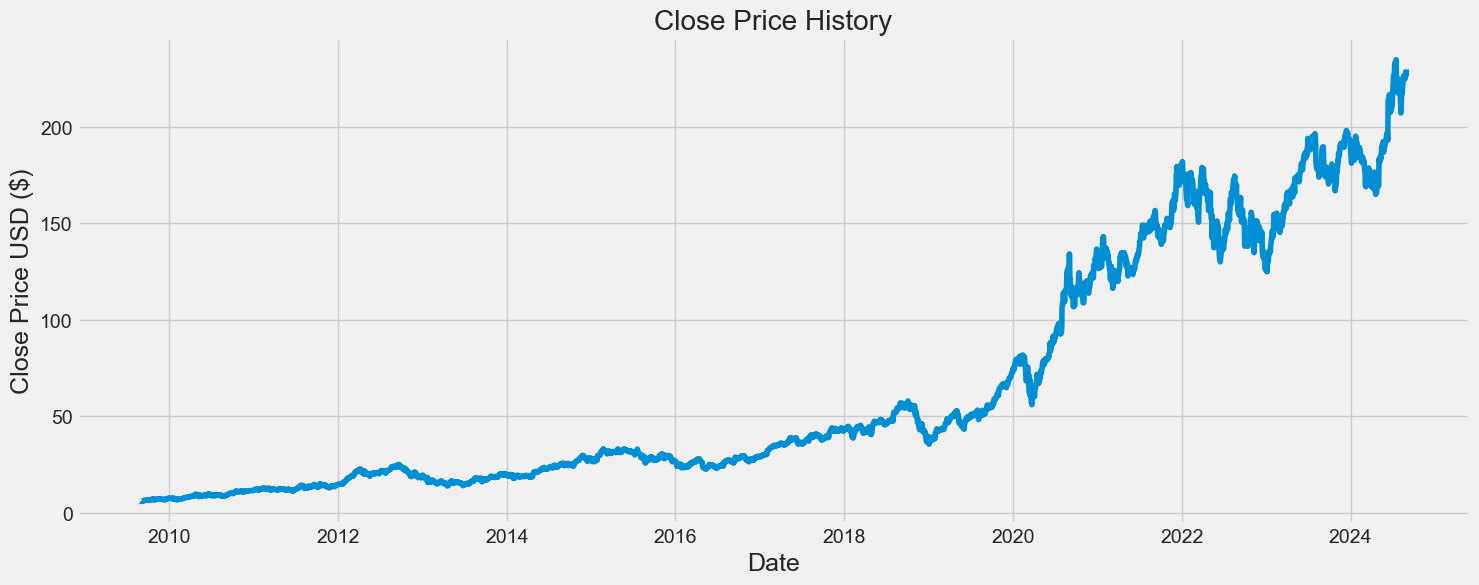

In [4]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
# Create a new dataframe with only the 'Close colum
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [7]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# x_train.shape

[array([4.72715522e-04, 1.87197363e-05, 0.00000000e+00, 2.13734521e-04,
       8.00339027e-04, 1.20908833e-03, 9.29829528e-04, 1.15136481e-03,
       1.08895874e-03, 1.33234031e-03, 1.55699381e-03, 2.60383263e-03,
       3.02194284e-03, 3.09526997e-03, 2.93925897e-03, 3.01102178e-03,
       3.17015516e-03, 2.90805594e-03, 2.68183812e-03, 3.27156085e-03,
       3.15143334e-03, 3.14675497e-03, 2.44626356e-03, 3.07654606e-03,
       3.25127888e-03, 3.87376479e-03, 3.91121051e-03, 3.75831982e-03,
       3.94553176e-03, 3.99857692e-03, 3.87532911e-03, 4.07346419e-03,
       3.95957313e-03, 3.56798341e-03, 3.85036460e-03, 5.23886620e-03,
       6.19989876e-03, 6.24358092e-03, 6.04700598e-03, 5.81923427e-03,
       5.02201554e-03, 4.24663686e-03, 4.86288008e-03, 3.63819023e-03,
       3.76455834e-03, 3.67719193e-03, 3.99857692e-03, 4.50093532e-03,
       4.54929585e-03, 5.66010088e-03, 5.89723976e-03, 5.93936177e-03,
       5.74278892e-03, 6.12657580e-03, 6.46668052e-03, 6.52440404e-03,
     

In [8]:
firstLayer = range(32, 256, 32)
secondLayer = range(32, 128, 32)
firstDensity = range(10, 50, 10)
secondDensity = range(1, 6, 2)
epochs = range(1, 3, 1)

counter = 0

colums = ['Units firstLayer', 'Units SecondLayer','firstDensity', 'secondDensity', 'Epochs' , 'MSE', 'RMSE', 'MAE', 'R2']
results = pd.DataFrame(columns=colums)

for fl in firstLayer:
    for sl in secondLayer:
        for fd in firstDensity:
            # for sd in secondDensity:
            for ep in epochs:
                # Build the LSTM model
                model = Sequential()
                model.add(LSTM(units=fl, return_sequences=True, input_shape=(x_train.shape[1], 1)))
                model.add(LSTM(units=sl, return_sequences=False))
                
                model.add(Dense(fd))
                model.add(Dense(1))

                # Compile the model
                model.compile(optimizer='adam', loss='mean_squared_error')

                # Train the model
                model.fit(x_train, y_train, batch_size=1, epochs=ep)

                # Create the testing data set
                # Create a new array containing scaled values from index 1543 to 2002 
                test_data = scaled_data[training_data_len - 60: , :]

                # Create the data sets x_test and y_test
                x_test = []
                y_test = dataset[training_data_len:, :]

                for i in range(60, len(test_data)):
                    x_test.append(test_data[i-60:i, 0])

                # Convert the data to a numpy array
                x_test = np.array(x_test)

                # Reshape the data
                x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

                # Get the models predicted price values 
                predictions = model.predict(x_test)
                predictions = scaler.inverse_transform(predictions)

                # Assuming y_test are the actual values and y_pred are the predicted values
                mse = mean_squared_error(y_test, predictions)
                rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
                #rmse = root_mean_squared_error(y_test, predictions)
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)
    
                results.loc[counter] = [fl,  sl, fd, 1, ep, mse, rmse, mae, r2]
                counter +=1
                print('counter',counter)


6/6 [==============================] - 1s 11ms/step
counter 1
Epoch 1/2
3527/3527 [==============================] - 69s 19ms/step - loss: 9.4766e-04
Epoch 2/2
6/6 [==============================] - 1s 11ms/step
counter 2
6/6 [==============================] - 1s 11ms/step
counter 3
Epoch 1/2
3527/3527 [==============================] - 72s 19ms/step - loss: 5.6400e-04
Epoch 2/2
6/6 [==============================] - 1s 11ms/step
counter 4
6/6 [==============================] - 1s 11ms/step
counter 5
Epoch 1/2
3527/3527 [==============================] - 71s 19ms/step - loss: 7.6608e-04
Epoch 2/2
6/6 [==============================] - 1s 11ms/step
counter 6
6/6 [==============================] - 1s 11ms/step
counter 7
Epoch 1/2
3527/3527 [==============================] - 70s 19ms/step - loss: 7.9375e-04
Epoch 2/2
6/6 [==============================] - 1s 11ms/step
counter 8
6/6 [==============================] - 1s 13ms/step
counter 9
Epoch 1/2
3527/3527 [=============================

In [9]:
display(results)

,Units firstLayer,Units SecondLayer,firstDensity,secondDensity,Epochs,MSE,RMSE,MAE,R2
0,32.0,32.0,10.0,1.0,1.0,28.425685,5.331574,4.359629,0.923343
1,32.0,32.0,10.0,1.0,2.0,45.542670,6.748531,5.316730,0.877182
2,32.0,32.0,20.0,1.0,1.0,77.696080,8.814538,7.678892,0.790472
3,32.0,32.0,20.0,1.0,2.0,32.381967,5.690516,4.620347,0.912674
4,32.0,32.0,30.0,1.0,1.0,88.186245,9.390753,7.649045,0.762183
...,...,...,...,...,...,...,...,...,...
163,224.0,96.0,20.0,1.0,2.0,25.700465,5.069563,3.954342,0.930692
164,224.0,96.0,30.0,1.0,1.0,1115.785598,33.403377,32.946630,-2.009007
165,224.0,96.0,30.0,1.0,2.0,19.588372,4.425875,3.500383,0.947175
166,224.0,96.0,40.0,1.0,1.0,30.738465,5.544228,4.336706,0.917106


In [10]:
import os
import pickle

results.sort_values(by=['MSE','RMSE'] ).to_csv('results 15 years.csv', decimal=',')

# filename = "results.pkl"

# if not os.path.isfile(filename):
#    with open(filename,'wb') as file:
#        pickle.dump(results, file)
#    file.close()

